# **Projeto Ponta a Ponta  : Identificando Fake news em noticias sobre politica estadunidense**

--------

O projeto a seguir tem como objetivo principal identificar fake news (noticias falsas) dado um cojunto de dados de noticias politicas estadunidense.

# Parte 1 : Coleta de dados

---



Abaixo está a importação de pacotes essenciais.

In [ ]:
import pandas as pd

import seaborn as sns

sns.set_style("whitegrid") # estilização dos gráficos
sns.set(rc={'figure.figsize':(12,12)}) #tamanho dos gráficos

df_fake = pd.read_csv('fake.csv')
df_true = pd.read_csv('true.csv')

Abaixo está o código para a coleta de dados. Observe que os dados estão divididos entre fake e true. Isso significa que as fake news estão separadas das noticias verdadeiras.

In [ ]:
import requests

#fazendo a requisição dos dados
dados_brutos_fake = requests.get('https://raw.githubusercontent.com/MSR1805200/Portifolio/main/aprendizado_maquina_ufsc/projeto_final/Fake.csv',allow_redirects=True)
dados_brutos_true = requests.get('https://raw.githubusercontent.com/MSR1805200/Portifolio/main/aprendizado_maquina_ufsc/projeto_final/True.csv',allow_redirects=True)

#criando dois arquivos csv e colocando os dados dentro deles
open('fake.csv','wb').write(dados_brutos_fake.content)
open('true.csv','wb').write(dados_brutos_true.content)

14

In [ ]:
import warnings           
warnings.filterwarnings('ignore') #função para retirar os avisos do pandas

Abaixo estou criando uma nova coluna chamada label que servirá para guardar o rótulo de cada instancia.

In [ ]:
df_fake['label'] = 1  # é fake news
df_true['label'] = 0  # não é fake news

Abaixo estou juntando os dois dataframes em um só.

In [ ]:
df = df_fake.append(df_true,ignore_index=True) 

In [ ]:
df.info() #informações adcionais sobre o dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


# Parte 2 : Divisão e Pré-processamento dos dados

---

Observe abaixo que os dados estão um pouco desbalanceados em relação ao rótulo, logo se faz necessário a divisão baseadas em estratificação.

In [ ]:

df['label'].value_counts().sort_values(ascending = False) #mais fake news do que noticias verdadeiras


1    23481
0    21417
Name: label, dtype: int64

A função train_test_split já possui a opção de estratificar os dados.

In [ ]:
from sklearn.model_selection import train_test_split


train_set,test_set = train_test_split(df, shuffle = True,  #embaralhamento 
                                      test_size=0.30  #tamanho dos dados de teste é 30% dos dados
                                      ,stratify = df['label'] #método de estratificação baseado no rótulo
                                      , random_state = 42)

Observe que a coluna date tem o ano, mês e dia da noticia. Vamos criar duas colunas para armazenar o ano e o mês para a retirada de insights.

In [ ]:
train_set['date'].head(5)

Poderiamos retirar facilmente o ano e o mês convertendo a string no tipo date, todavia alguns formatos que foram utilizados não batem com o padrão requerido para a conversão. Logo se faz necessário outra técnica para retirar os dados que queremos.

In [ ]:
train_set['date'].sample(15, random_state = 42)

Abaixo está o código para a retirada do ano e do mês. Foi utilizada a técnica de expressões regulares para tratar os dados. As expressões regulares são comandos para manipulação de caracteres que podem ser utilizados em várias linguagens de programação.



In [ ]:
import re

train_set['year'] = train_set['date'].apply(lambda x : ''.join(re.findall(r'[0-9][0-9][0-9][0-9]',x))) #pegue 4 numeros consecutivos( ex: 2017)

train_set['mounth'] = train_set['date'].apply(lambda x : ''.join(re.findall(r'[A-Za-z+]',x))) #pegue apenas letras (ex : 18-may-2017  -> may)
train_set['mounth'] = train_set['mounth'].apply(lambda x : ''.join(re.sub(r'https\S+','',x))) #retire links(alguns vieram com links) 
train_set['mounth'] = train_set['mounth'].apply(lambda x : ''.join(re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x))) #(em alguns dados aparece january envés de jan)


Abaixo está todos os meses préprocessados. Observe que há uma string vazia, isso significa que em alguns casos não houve meses para retirar, logo pode ser considerado como dados faltantes.

In [ ]:
train_set['mounth'].unique() # '' significa dados faltantes

array(['Jul', 'Nov', 'Jan', 'Apr', 'May', 'Sep', 'Dec', 'Oct', 'Feb',
       'Mar', 'Aug', 'Jun', ''], dtype=object)

In [ ]:
train_set['mounth'].value_counts() #são 8 dados faltantes

Nov    3877
Oct    3854
Sep    3575
Dec    3214
Mar    2314
Jan    2203
May    2202
Apr    2129
Feb    2057
Jun    2031
Jul    2010
Aug    1954
          8
Name: mounth, dtype: int64

Abaixo está um comando para transformar as strings vazias em tipo null. 

In [ ]:
import numpy as np

train_set.loc[ train_set['year'] == '', 'year'] = np.nan
train_set.loc[ train_set['mounth'] == '','mounth' ] = np.nan

Veja que são 24 dados faltantes para o ano e 8 para os meses.

In [ ]:
train_set.isnull().sum()

title       0
text        0
subject     0
date        0
label       0
year       29
mounth      8
dtype: int64

Observe abaixo que há links no title também.

In [ ]:
train_set[train_set['year'].isnull()] 

,title,text,subject,date,label,year,mounth
9052,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,19-Feb-18,1,NaN,Feb
9058,IT BEGINS…RINO MEGA-DONOR Threatens Jeb Bush: ...,A longtime Republican Party donor based in Flo...,politics,18-Feb-18,1,NaN,Feb
9082,HUH? RAPPER JAY-Z Compares Trayvon Martin to M...,Rapper Jay-Z attended the Peace Walk & Peace T...,politics,15-Feb-18,1,NaN,Feb
9084,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,14-Feb-18,1,NaN,Feb
9083,The DIRTY TRUTH About DACA Recipients…Where Th...,"Yesterday, a second U.S. judge on Tuesday bloc...",politics,15-Feb-18,1,NaN,Feb
9068,JUST IN: PRESIDENT TRUMP AND FIRST LADY Make S...,"President Trump visits Florida hospital, prai...",politics,16-Feb-18,1,NaN,Feb
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,NaN,NaN
9059,BUSTED! Maxine Waters’ Ties to Black Nationali...,We reported that Maxine Waters and members of ...,politics,18-Feb-18,1,NaN,Feb
9069,BREAKING: FL GOV RICK SCOTT Calls for FBI Dire...,"While the left points the finger at guns, guns...",politics,16-Feb-18,1,NaN,Feb
9078,"WHAT’S WRONG WITH PELOSI? Nancy Stutters, Stam...",What s wrong with Pelosi? Nancy Pelosi is supp...,politics,15-Feb-18,1,NaN,Feb


Como vamos utilizar apenas o title para realizar a predição então não há necessidade de realizar técnicas de imputação de dados, porém se fosse necessário bastaria observar a coluna text para saber sobre os meses e o anos de cadas dado faltante.

# Parte 3 : Análise Exploratória

---

Abaixo está uma análise exploratória dos dados cobrindo diversas informações. 

Text(0.5, 0, 'mês')

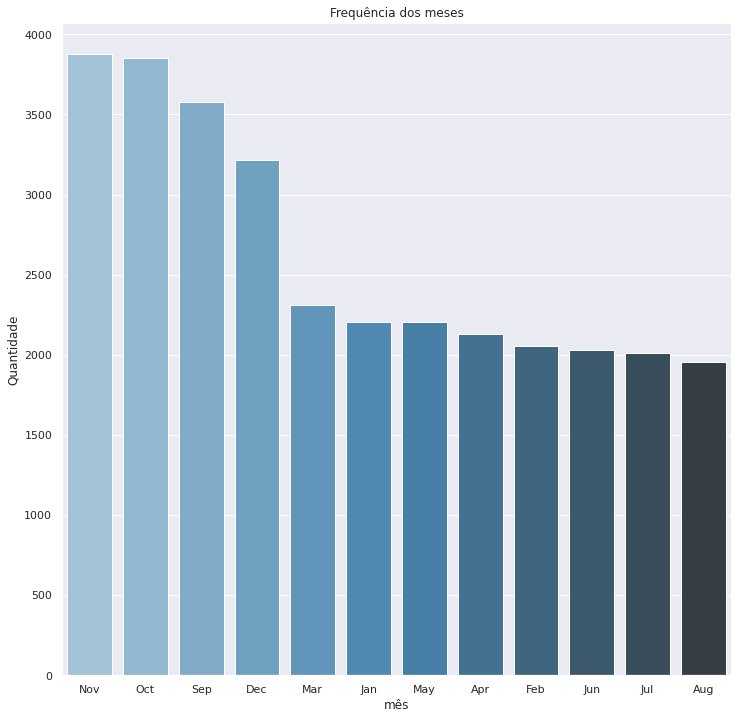

In [ ]:
mes = sns.barplot( x= train_set['mounth'].value_counts().sort_values(ascending = False).index, 
            y = train_set['mounth'].value_counts().sort_values(ascending = False).values,  palette='Blues_d')

mes.set_title('Frequência dos meses')
mes.set_ylabel('Quantidade')
mes.set_xlabel('mês')

Text(0.5, 0, 'Ano')

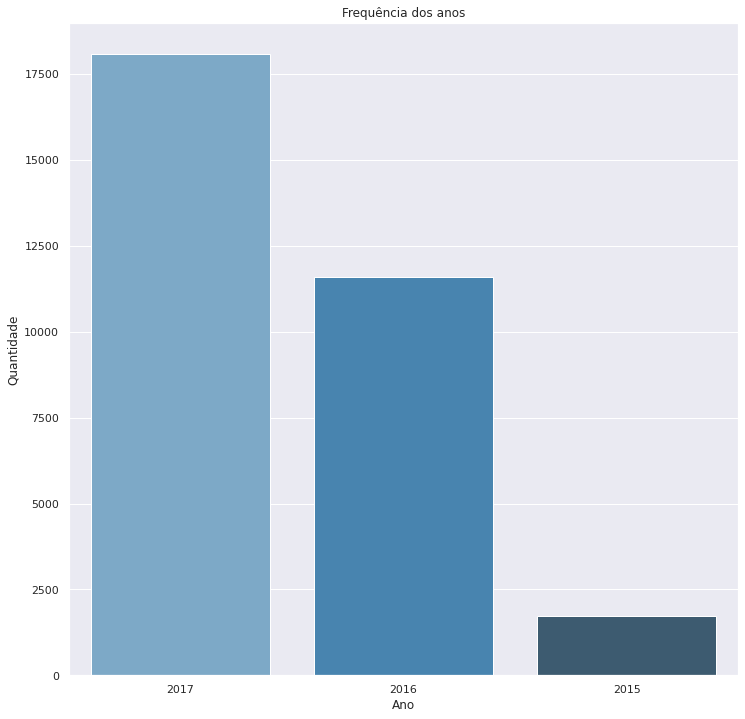

In [ ]:
ano =sns.barplot( x= train_set['year'].value_counts().sort_values(ascending = False).index, 
            y = train_set['year'].value_counts().sort_values(ascending = False).values,  palette='Blues_d')

ano.set_title('Frequência dos anos')
ano.set_ylabel('Quantidade')
ano.set_xlabel('Ano')

Text(0.5, 0, 'Mês')

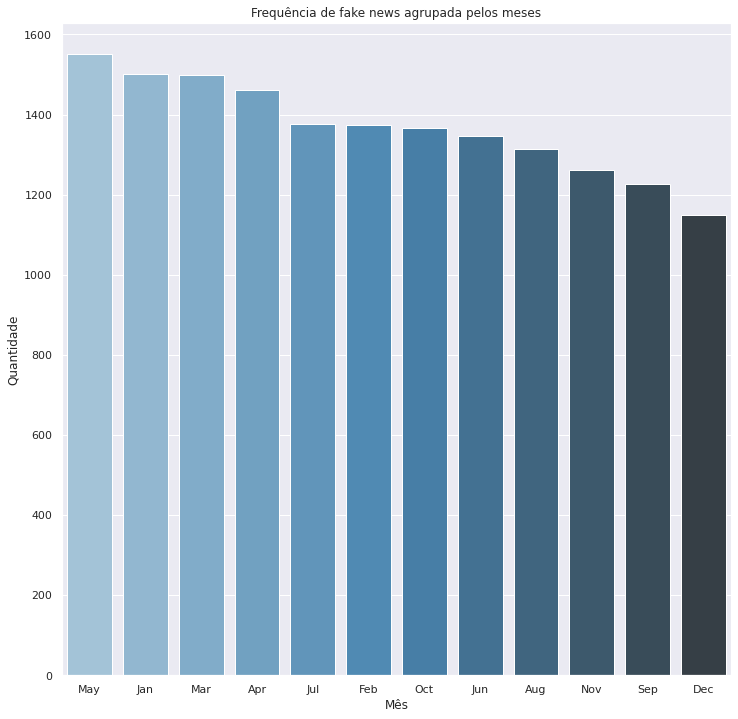

In [ ]:

mes_fake =sns.barplot( x =train_set['label'].groupby(train_set['mounth']).sum().sort_values(ascending = False).index,
            y = train_set['label'].groupby(train_set['mounth']).sum().sort_values(ascending = False).values,
            palette = 'Blues_d'
            )

mes_fake.set_title('Frequência de fake news agrupada pelos meses')
mes_fake.set_ylabel('Quantidade')
mes_fake.set_xlabel('Mês')

Text(0.5, 0, 'Ano')

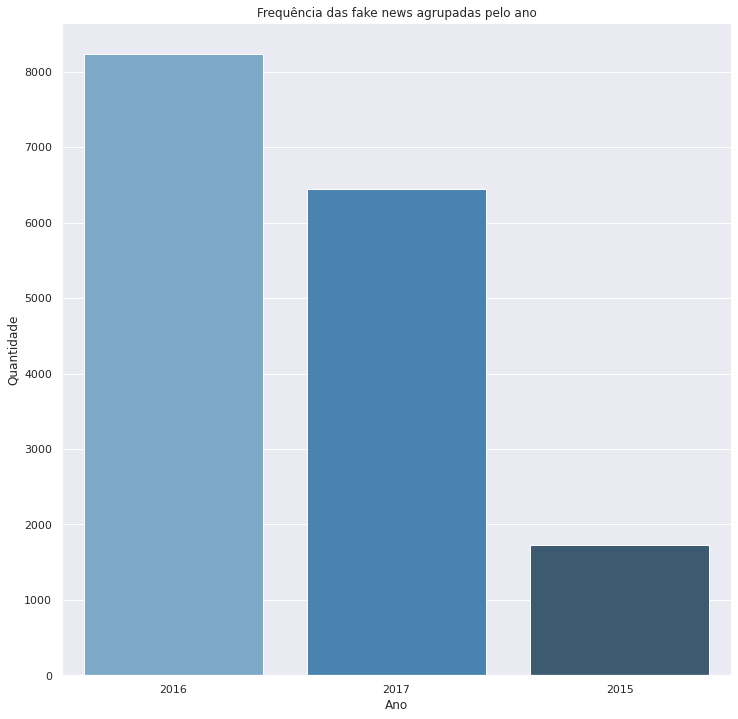

In [ ]:
ano_fake =sns.barplot(x = train_set['label'].groupby(train_set['year']).sum().sort_values(ascending = False).index,
            y =train_set['label'].groupby(train_set['year']).sum().sort_values(ascending = False).values,
            palette = 'Blues_d'
            )

ano_fake.set_title('Frequência das fake news agrupadas pelo ano')
ano_fake.set_ylabel('Quantidade')
ano_fake.set_xlabel('Ano')

Text(0.5, 0, 'Mês')

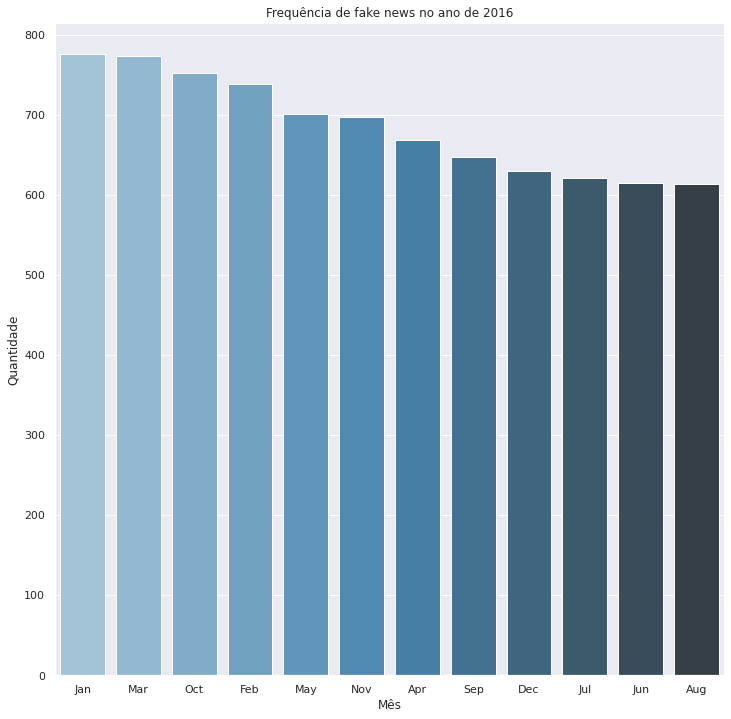

In [ ]:
fake_2016 = train_set[train_set['year'] == '2016']


fake_2016_plot = sns.barplot( x = fake_2016['label'].groupby(fake_2016['mounth']).sum().sort_values(ascending = False).index,
             y = fake_2016['label'].groupby(fake_2016['mounth']).sum().sort_values(ascending = False).values,
            palette = 'Blues_d'
)

fake_2016_plot.set_title('Frequência de fake news no ano de 2016')
fake_2016_plot.set_ylabel('Quantidade')
fake_2016_plot.set_xlabel('Mês')

Text(0.5, 0, 'Mês')

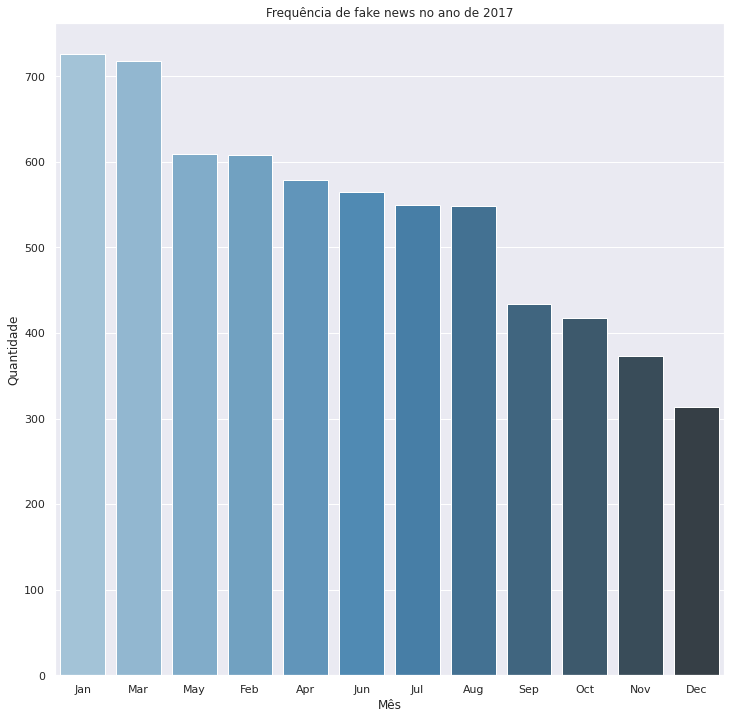

In [ ]:
fake_2017 = train_set[train_set['year'] == '2017']


fake_2017_plot = sns.barplot( x = fake_2017['label'].groupby(fake_2017['mounth']).sum().sort_values(ascending = False).index,
             y = fake_2017['label'].groupby(fake_2017['mounth']).sum().sort_values(ascending = False).values,
            palette = 'Blues_d'
)

fake_2017_plot.set_title('Frequência de fake news no ano de 2017')
fake_2017_plot.set_ylabel('Quantidade')
fake_2017_plot.set_xlabel('Mês')

Text(0.5, 0, 'Mês')

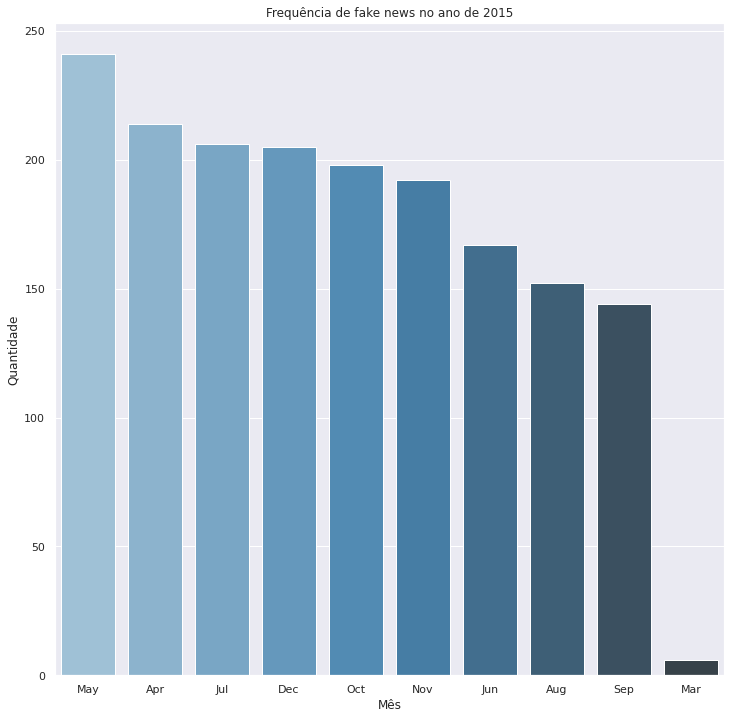

In [ ]:
fake_2015 = train_set[train_set['year'] == '2015']


fake_2015_plot = sns.barplot( x = fake_2015['label'].groupby(fake_2015['mounth']).sum().sort_values(ascending = False).index,
             y = fake_2015['label'].groupby(fake_2015['mounth']).sum().sort_values(ascending = False).values,
            palette = 'Blues_d'
)

fake_2015_plot.set_title('Frequência de fake news no ano de 2015')
fake_2015_plot.set_ylabel('Quantidade')
fake_2015_plot.set_xlabel('Mês')

Text(0.5, 0, 'Assunto')

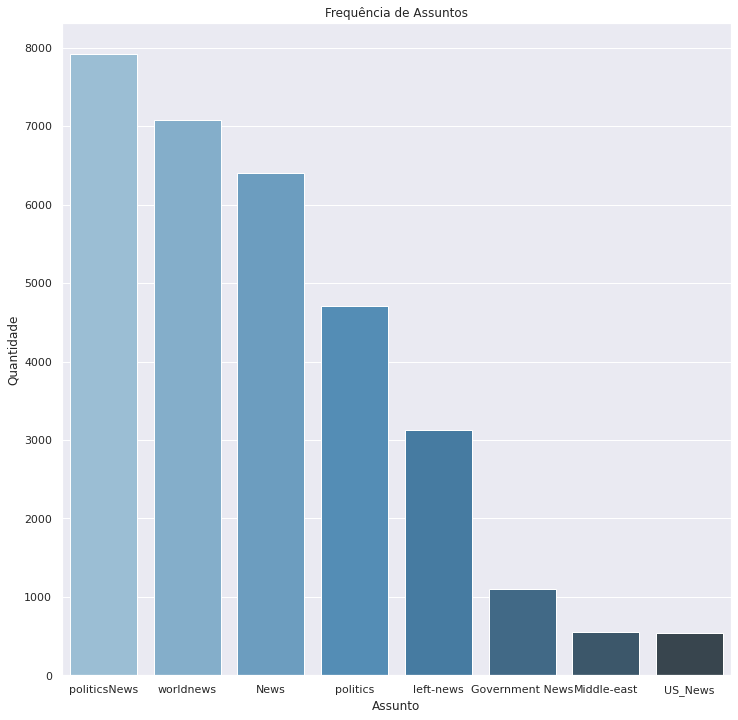

In [ ]:
subject =sns.barplot( x= train_set['subject'].value_counts().sort_values(ascending=False).index,
              y = train_set['subject'].value_counts().sort_values(ascending=False).values,
              palette = 'Blues_d'         
            )


subject.set_title('Frequência de Assuntos')
subject.set_ylabel('Quantidade')
subject.set_xlabel('Assunto')

Text(0.5, 0, 'Assunto')

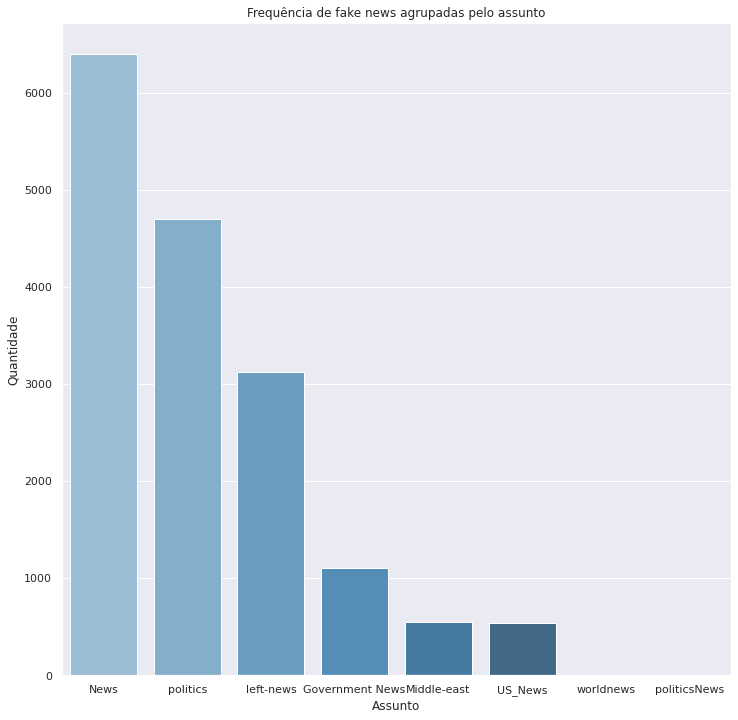

In [ ]:
subject_fake = sns.barplot(
    x = train_set['label'].groupby(train_set['subject']).sum().sort_values(ascending = False).index,
    y = train_set['label'].groupby(train_set['subject']).sum().sort_values(ascending = False).values,
    palette = 'Blues_d'
)

subject_fake.set_title('Frequência de fake news agrupadas pelo assunto')
subject_fake.set_ylabel('Quantidade')
subject_fake.set_xlabel('Assunto')

Abaixo está uma função para a criação de uma wordcloud (nuvem de palavras). Uma nuvem de palavras são um conjunto de palavras colocadas em um retangulo, onde o tamanho de cada uma está relacionada com a frequencia que ela se encontra em um dado.

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

def create_wordcloud(df):

  texto = " ".join(palavra for palavra in df.values)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color='black').generate(texto)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

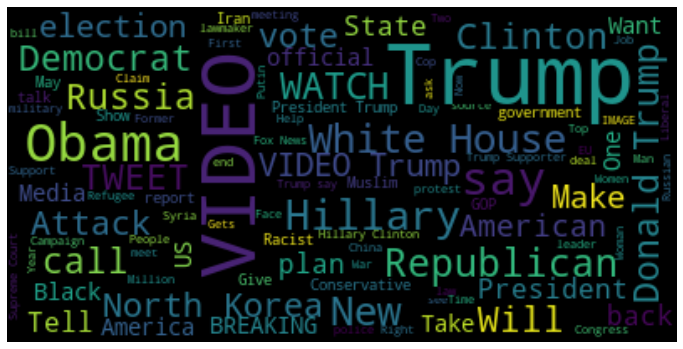

In [ ]:
create_wordcloud(train_set['title'])

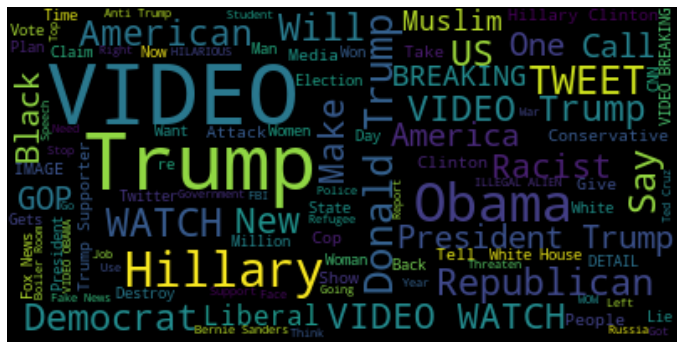

In [ ]:
fake_data = train_set[train_set['label'] == 1] #dados de fake news

create_wordcloud(fake_data['title'])

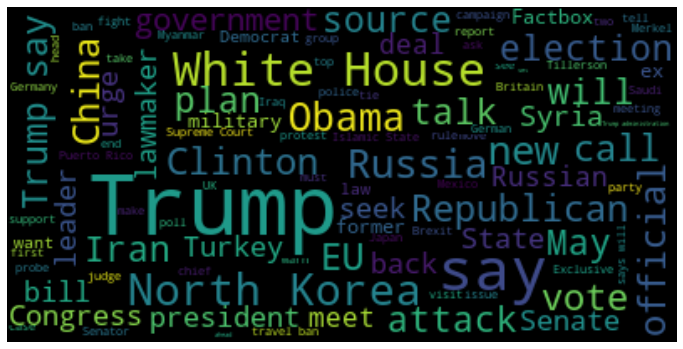

In [ ]:
fake_data = train_set[train_set['label'] == 0] #dados de noticias verdadeiras

create_wordcloud(fake_data['title'])

# Parte 4 : Treinamento, aprimoramento e teste 

----

Para realizar a transformação dos dados, foi utilizado duas técnicas: o bag of words e o valor tf–idf.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

x_train = train_set['title'].copy()
y_train = train_set['label'].copy()

pipe = Pipeline([
                 ('CV', CountVectorizer(strip_accents = 'unicode',lowercase= True,stop_words= 'english')),
                 ('TfidfT', TfidfTransformer())
])


x_tr = pipe.fit_transform(x_train)

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

rfc =RandomForestClassifier(random_state=42)

pred = cross_val_predict(rfc, x_tr, y_train, cv = 10 , n_jobs=-1)


print(classification_report(y_train,pred))


              precision    recall  f1-score   support

           0       0.92      0.95      0.93     14992
           1       0.95      0.92      0.94     16436

    accuracy                           0.94     31428
   macro avg       0.94      0.94      0.94     31428
weighted avg       0.94      0.94      0.94     31428



In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

pred = cross_val_predict(mnb,x_tr,y_train, cv =10)


print(classification_report(y_train,pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     14992
           1       0.93      0.95      0.94     16436

    accuracy                           0.93     31428
   macro avg       0.94      0.93      0.93     31428
weighted avg       0.93      0.93      0.93     31428



In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)

pred = cross_val_predict(lr ,x_tr,y_train, cv =10)

print(classification_report(y_train,pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     14992
           1       0.96      0.93      0.94     16436

    accuracy                           0.94     31428
   macro avg       0.94      0.94      0.94     31428
weighted avg       0.94      0.94      0.94     31428



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

pred = cross_val_predict(knn,x_tr,y_train, cv =10)


print(classification_report(y_train,pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     14992
           1       0.92      0.86      0.89     16436

    accuracy                           0.89     31428
   macro avg       0.89      0.89      0.89     31428
weighted avg       0.89      0.89      0.89     31428



In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

pred = cross_val_predict(svc,x_tr,y_train, cv =10, n_jobs =-1)


print(classification_report(y_train,pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14992
           1       0.96      0.94      0.95     16436

    accuracy                           0.95     31428
   macro avg       0.95      0.95      0.95     31428
weighted avg       0.95      0.95      0.95     31428



In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)

pred = cross_val_predict(dtc,x_tr,y_train, cv =10, n_jobs = -1)


print(classification_report(y_train,pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     14992
           1       0.91      0.91      0.91     16436

    accuracy                           0.90     31428
   macro avg       0.90      0.90      0.90     31428
weighted avg       0.90      0.90      0.90     31428



O SVC e a regressão logistica tiveram um ótimo desempenho. Vamos observar o gráfico de aprendizado de cada uma.

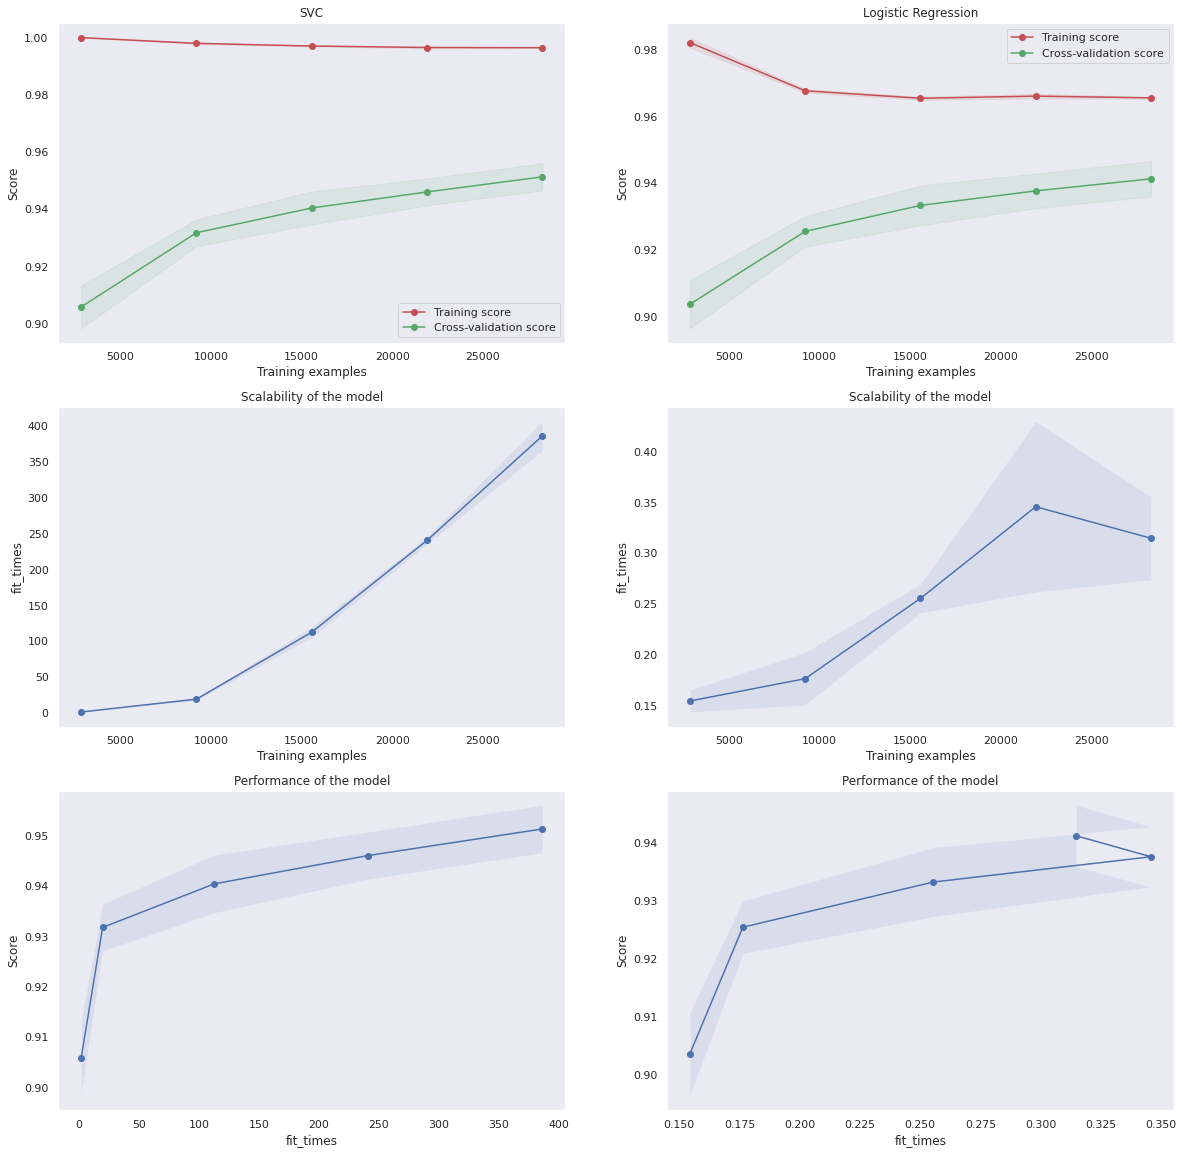

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(20,20))
list_est = [svc,lr]
list_title = [ 'SVC','Logistic Regression']
for i in range(len(list_est)):
  plot_learning_curve(estimator =list_est[i], title = list_title[i], X = x_tr, y = y_train, cv =10 ,  axes=axes[:, i], n_jobs= -1 )

plt.show()

O SVC possui uma maior pontuação, todavia sua escalabilidade é muito alta. Sendo assim foi escolhido a regressão logística.

In [ ]:
from sklearn.model_selection import GridSearchCV


params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            'max_iter' : [100,200,300,400,500]
          
           }
          ] 

grid = GridSearchCV(lr,params, cv =10)

grid.fit(x_tr,y_train)


modelo = grid.best_estimator_

In [ ]:
modelo

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
x_teste = test_set['title']
y_teste = test_set['label']

x_teste_tr = pipe.transform(x_teste)

modelo.fit(x_tr,y_train)

pred_final = modelo.predict(x_teste_tr)

print(classification_report(y_teste,pred_final))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6425
           1       0.95      0.95      0.95      7045

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.95     13470



# Parte 5 : Conclusão

---



Diante dos resultados observados, é notório afimar que o modelo está apto à entrar em produção.